In [1]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
import sys

sys.path.append("../src")

In [3]:
import data_handling as dh
import subsampling as ss
import plotting
import pipeline

In [4]:
site_names = {
            'Central' : "Central Pond",
            'Foliage' : "Foliage",
            'Carp' : "Carp Pond",
            'Telephone' : "Telephone Field",
            'Opposite' : "Opposite Carp Pond",
            'Fallen' : "Fallen Tree"
            }

freq_groups = {
            'lf_' : [0, 46000],
            'hf_' : [35000, 125000],
            '' :[0, 125000]
            }

dc_colors = {
            '1800e1800' : 'cyan',
            '60e360' : 'red',
            '300e1800' : 'orange'
            }

In [5]:
freq_group = ''
site_key = "Central"
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800e1800"

data_params = dict()
data_params["site_name"] = site_names[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = freq_group
data_params["freq_tags"] = freq_groups[freq_group]
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params

{'site_name': 'Central Pond',
 'site_tag': 'Central',
 'type_tag': '',
 'freq_tags': [0, 125000],
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800e1800', '300e1800', '60e360'],
 'cur_dc_tag': '1800e1800'}

In [6]:
cfg = dict()
cfg["read_csv"] = True
cfg["save_activity_grid"] = True
cfg["save_presence_grid"] = True
cfg["save_dc_night_comparisons"] = True
cfg["save_activity_dc_comparisons"] = True
cfg["save_presence_dc_comparisons"] = True
cfg["dc_color_mappings"] = dc_colors
cfg["show_plots"] = False
cfg

{'read_csv': True,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'dc_color_mappings': {'1800e1800': 'cyan',
  '60e360': 'red',
  '300e1800': 'orange'},
 'show_plots': False}

,Number_of_Detections (1800e1800),Number_of_Detections (300e1800),Number_of_Detections (60e360)
Date_and_Time_UTC,,,
2022-08-19 03:00:00,1,0,0
2022-08-19 03:30:00,114,0,10
2022-08-19 04:00:00,1761,98,144
2022-08-19 04:30:00,2512,475,407
2022-08-19 05:00:00,244,12,31
...,...,...,...
2022-08-29 11:00:00,13,0,0
2022-08-29 11:30:00,14,0,1
2022-08-29 12:00:00,94,22,33


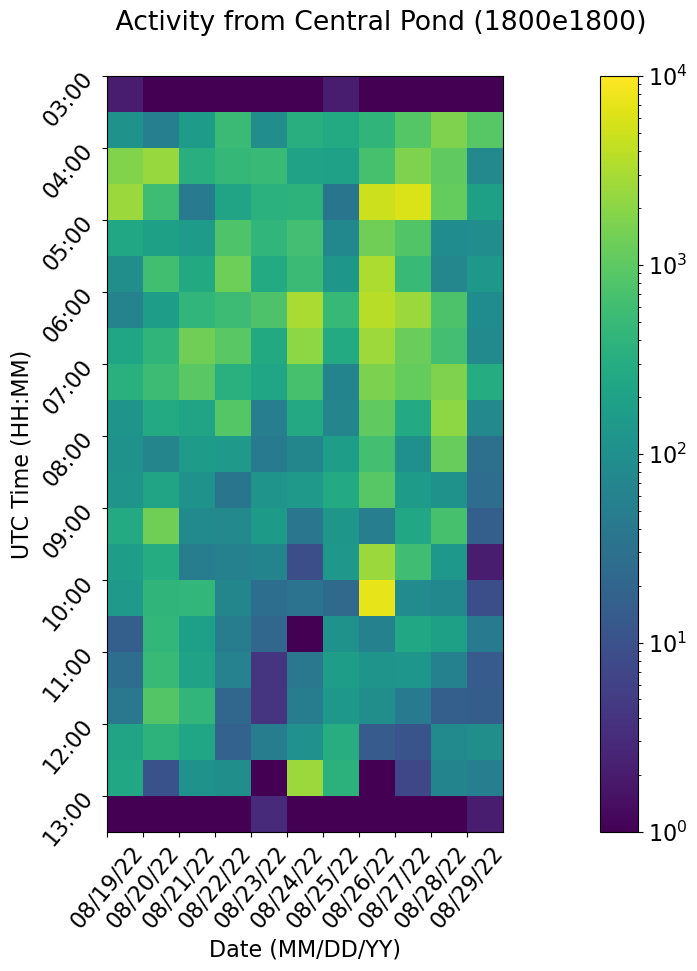

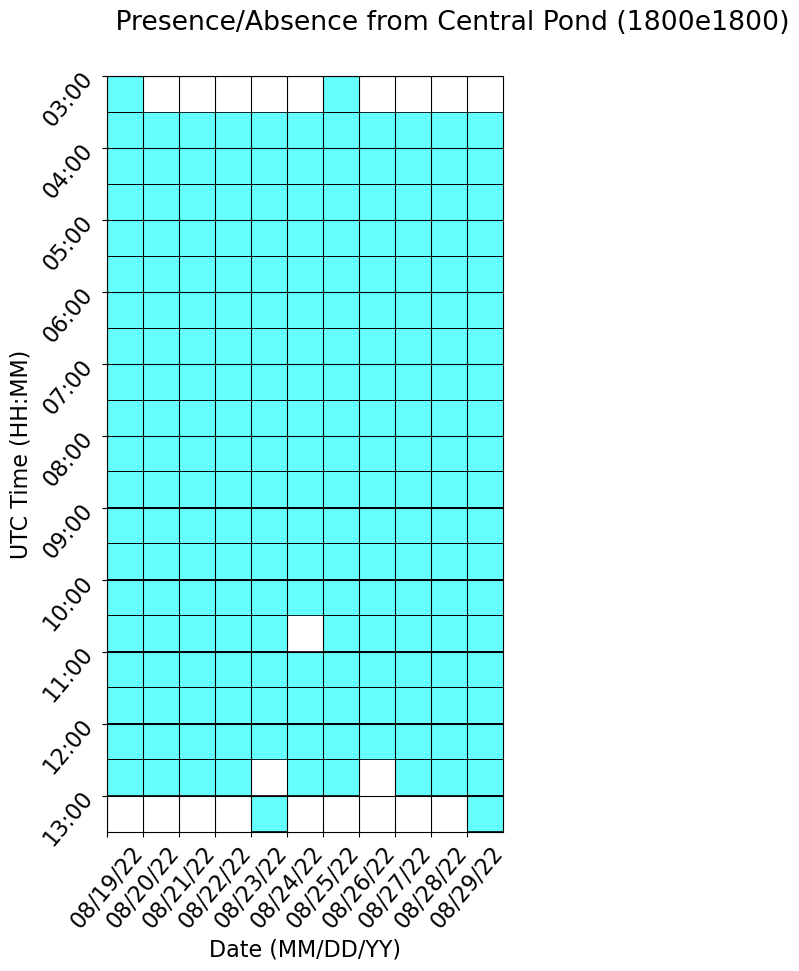

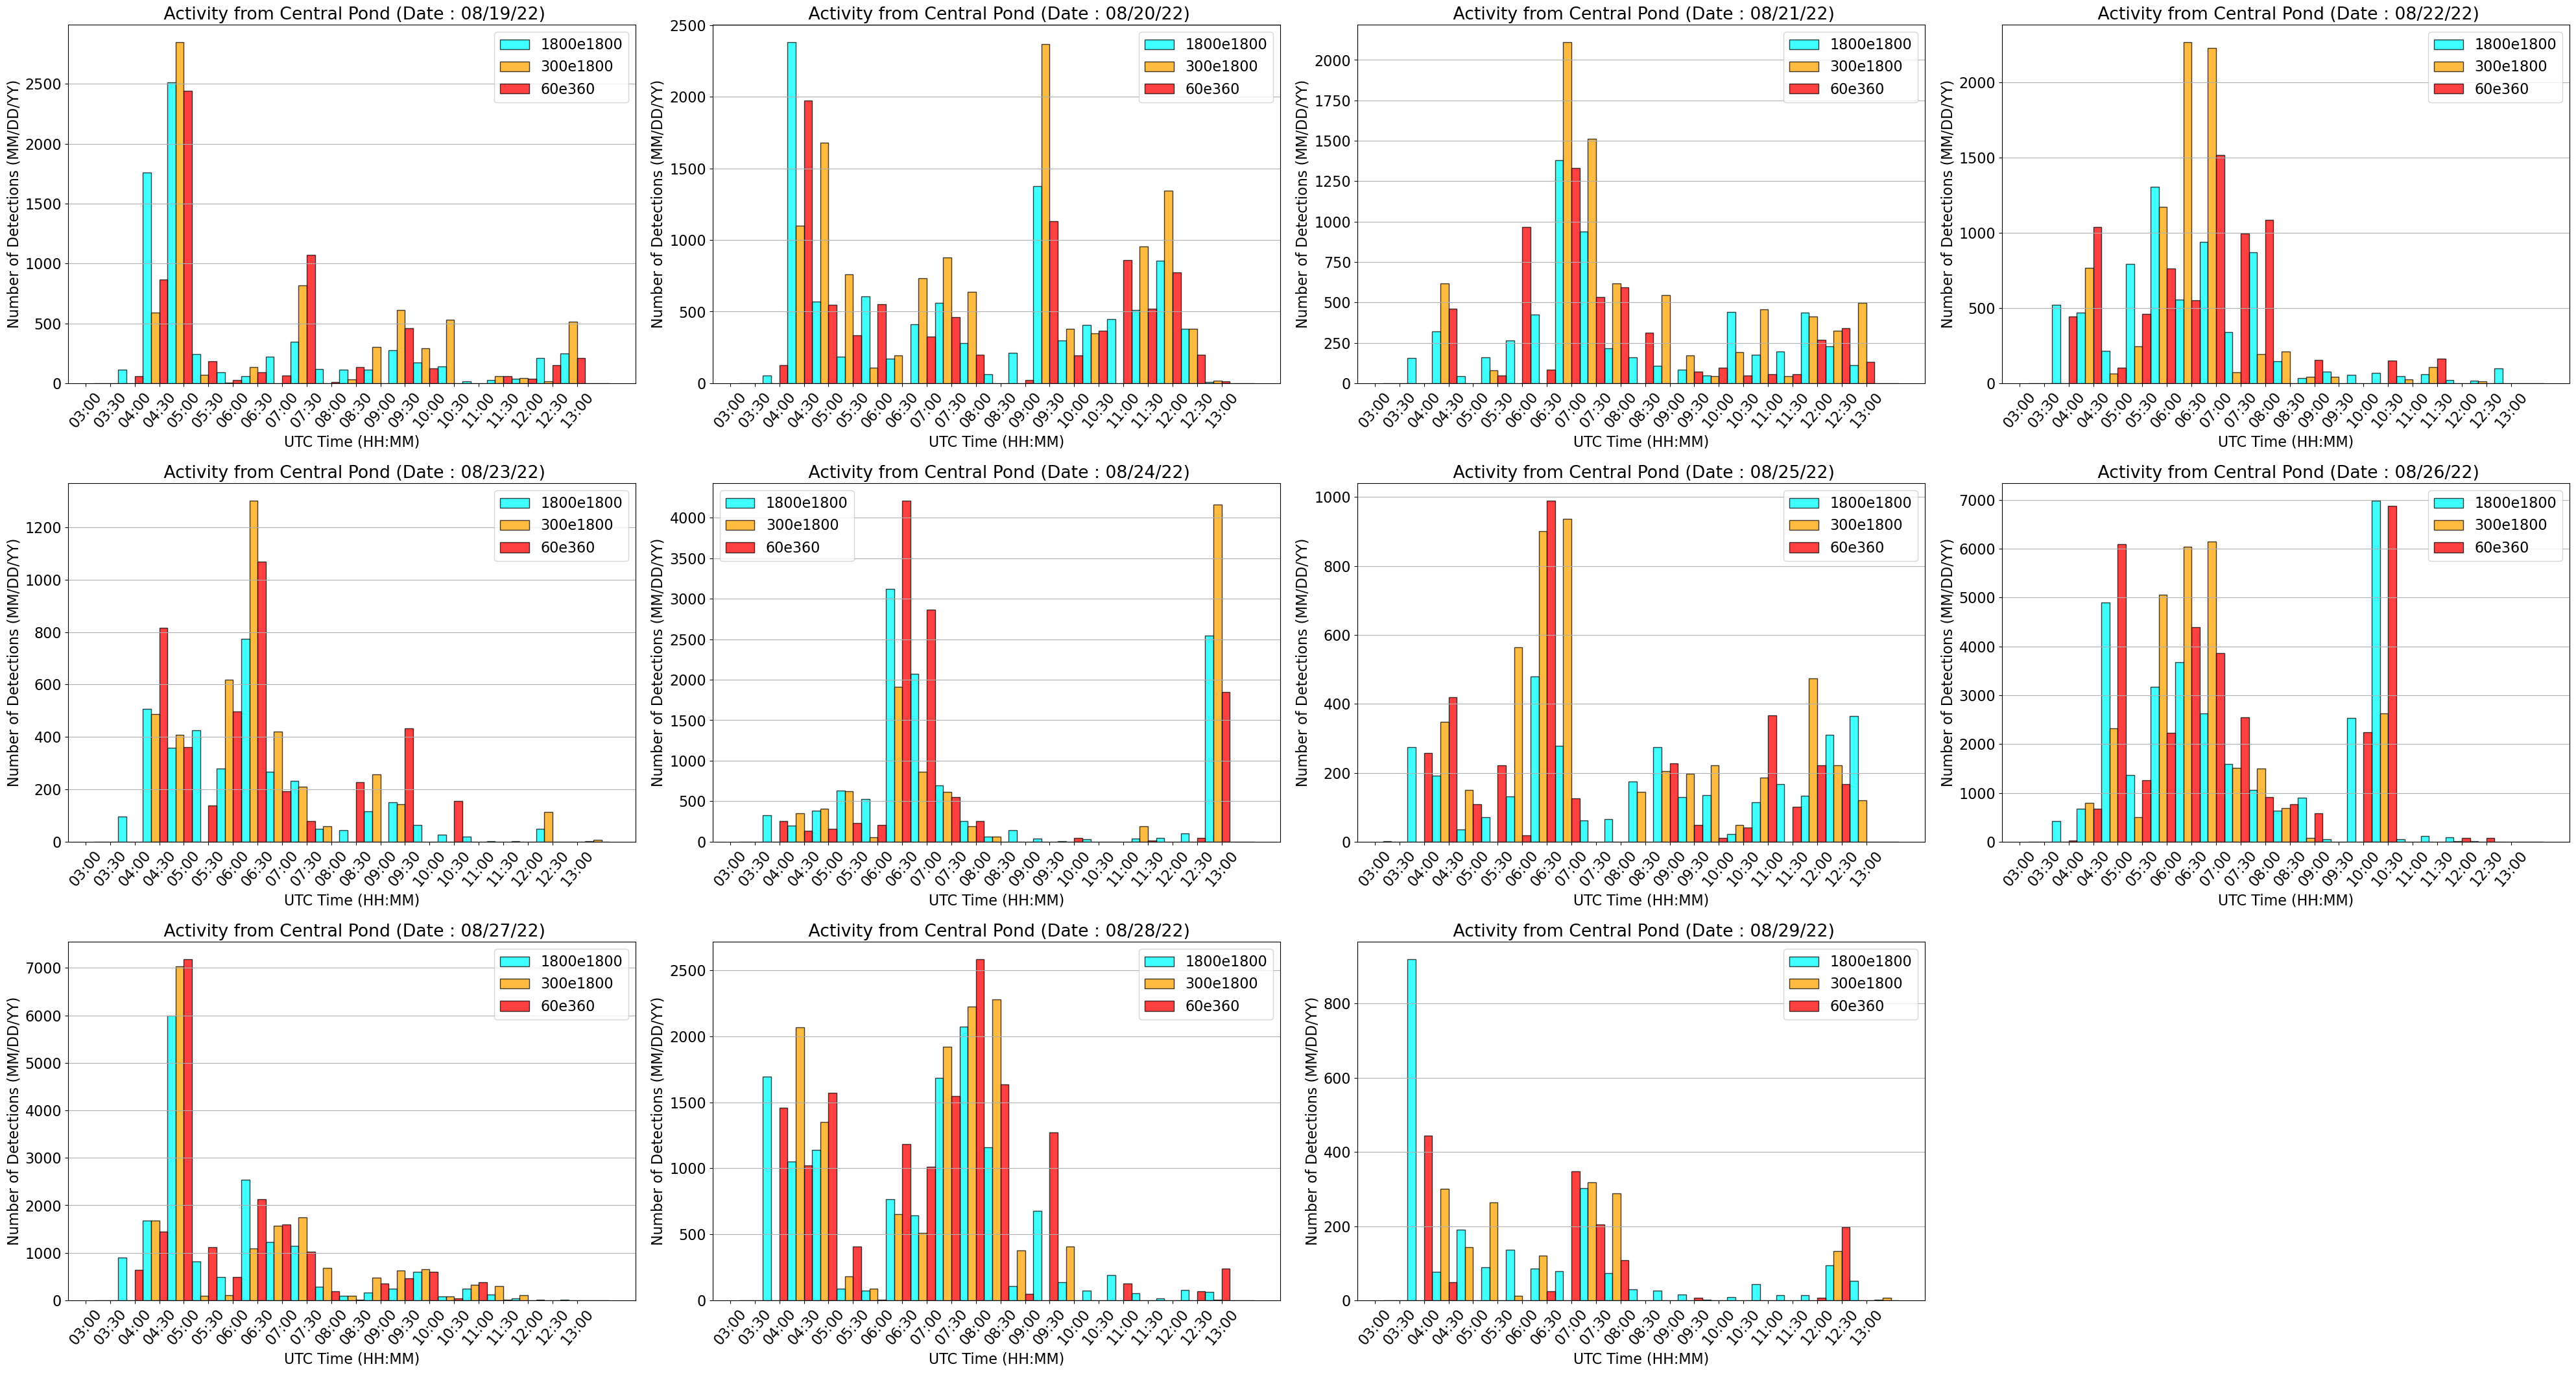

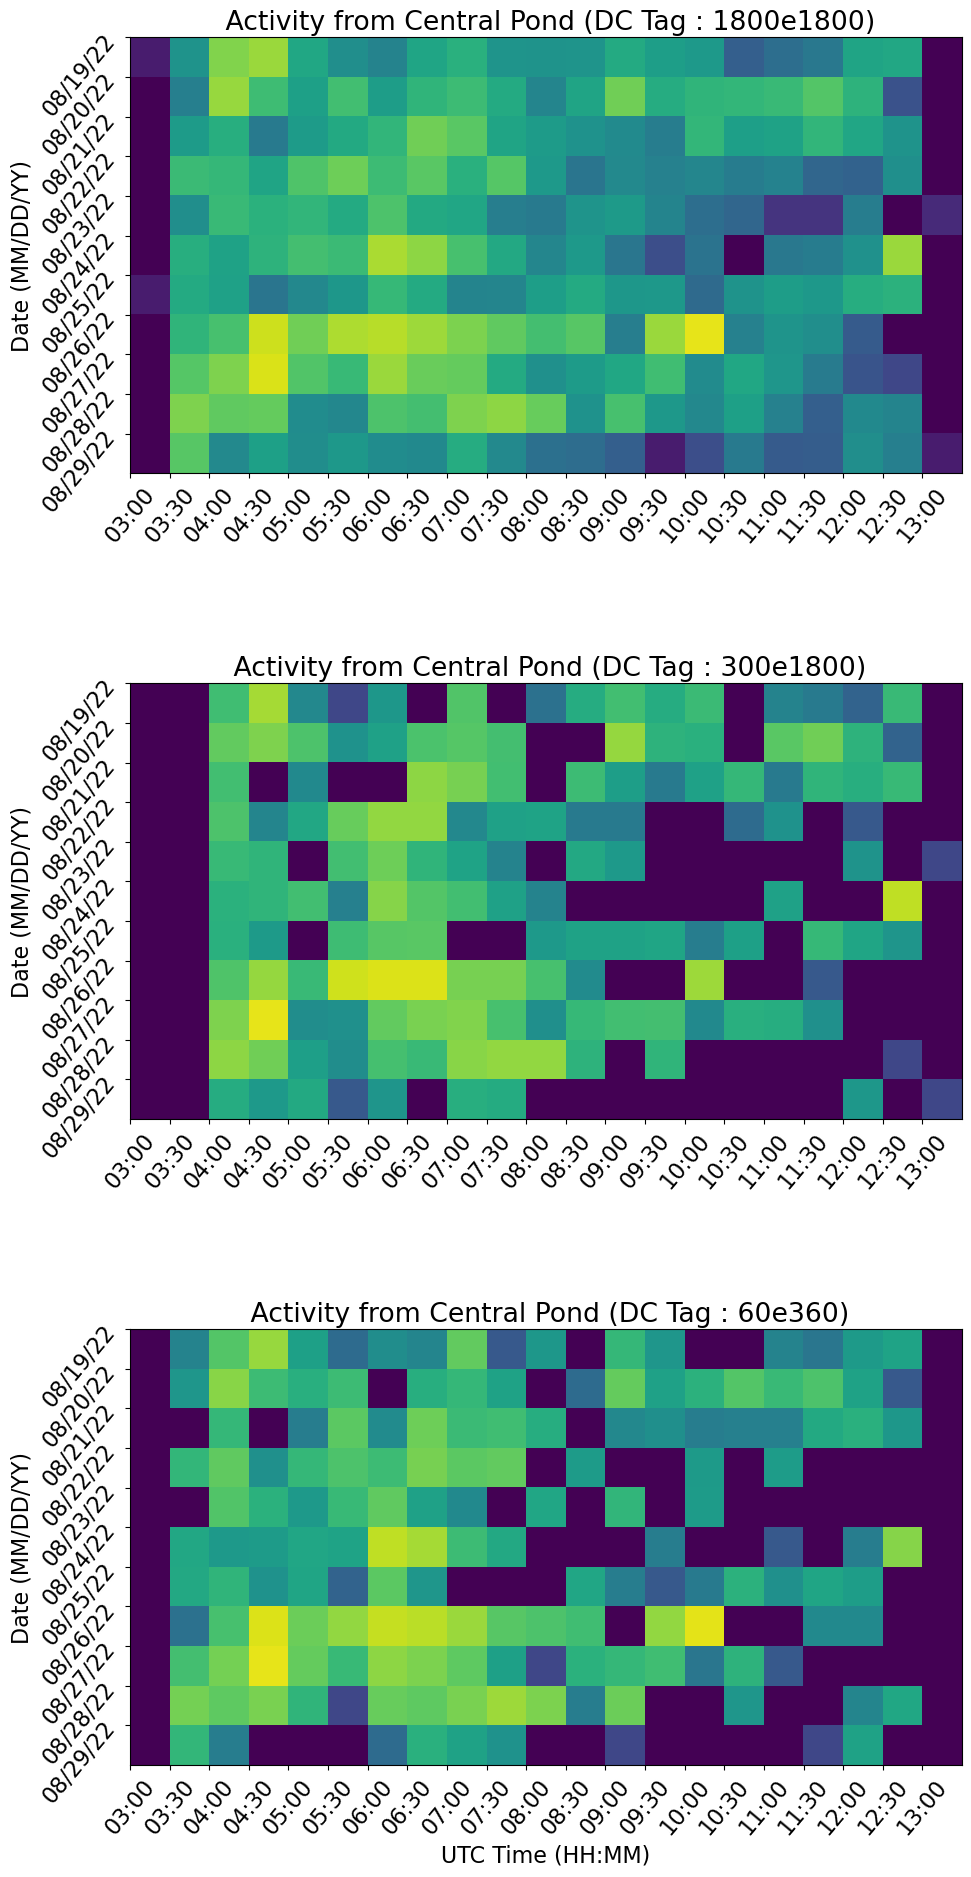

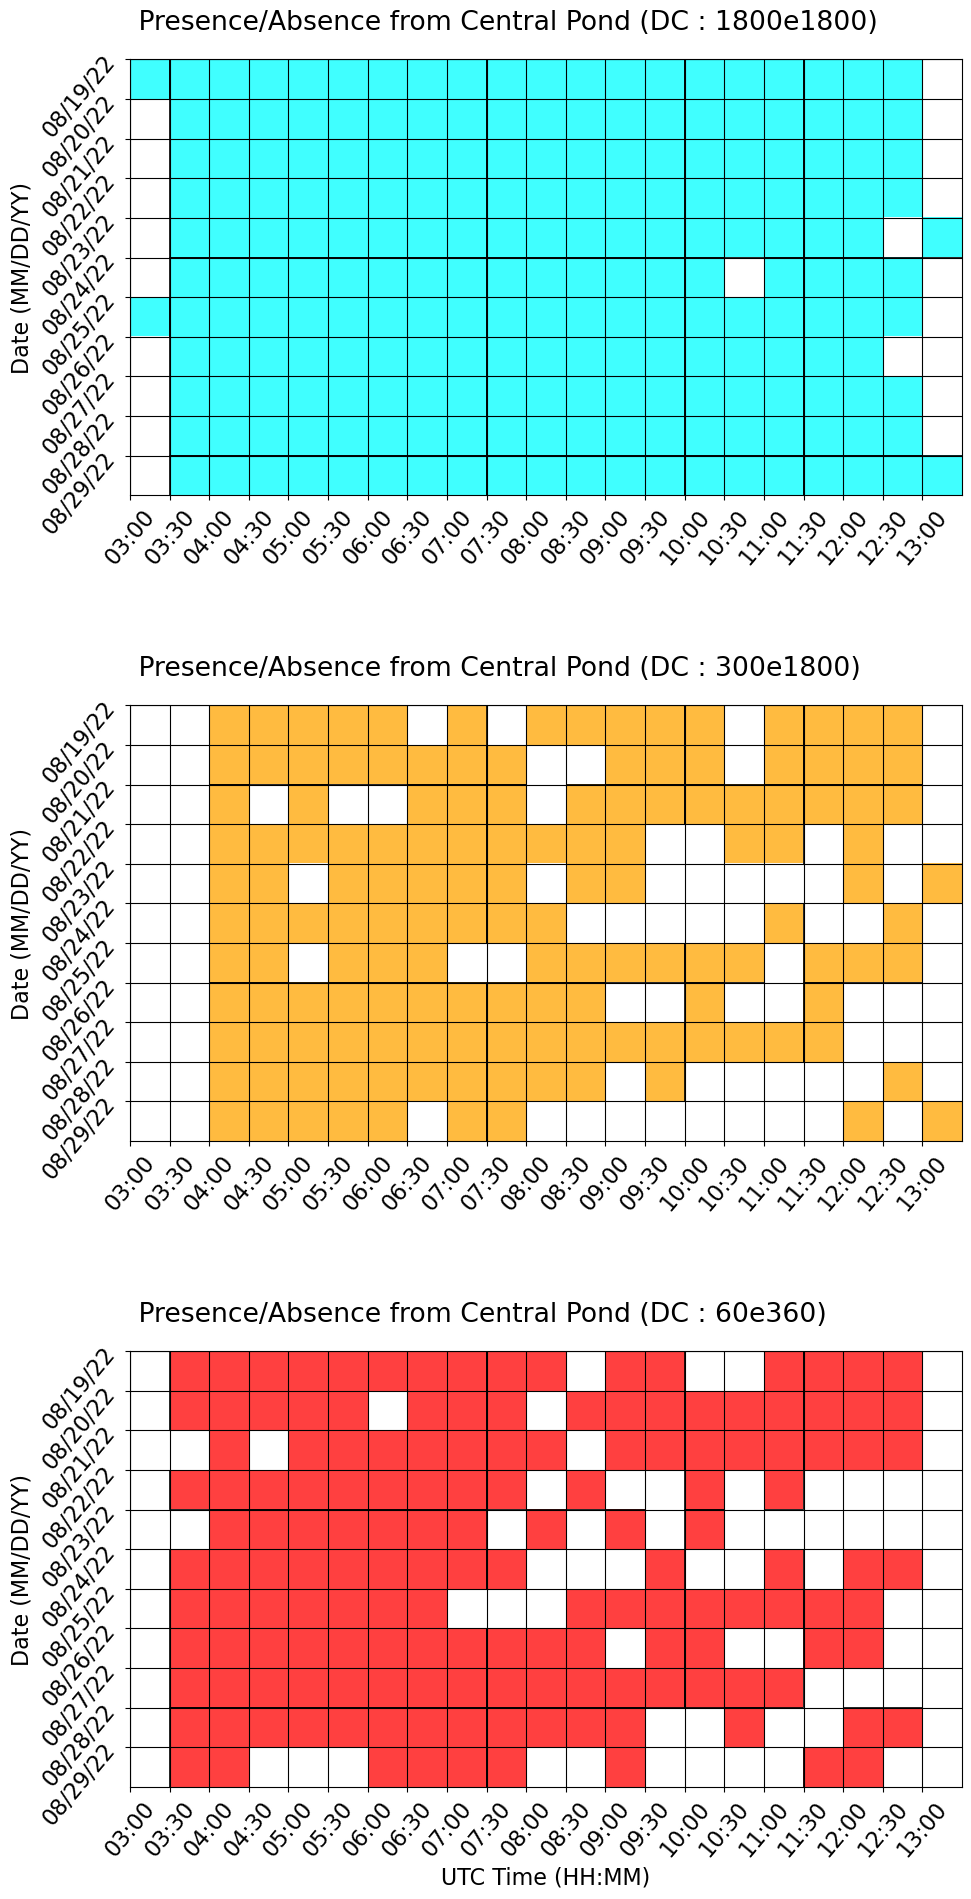

In [7]:
pipeline.run(data_params, cfg)